This notebook shows how to initialize a model with a network.  
It means we'll run the code for only 1 step.

In [1]:
# general packages
import random
import networkx as nx
from matplotlib import pyplot as plt

In [2]:
# Mesa packages
import mesa
import multilevel_mesa as mlm

In [3]:
class Agent_Rnd_Trader(mesa.Agent):
    def __init__(self, unique_id, model, wealth, position, order):
        super().__init__(unique_id, model)
        
        self.type = 'random'
        
        # DOF Agent
        self.wealth = round(wealth * ( 1. + 0.1 * random.uniform(-1, 1) ), 2) # cash
        self.position = position # initial position, buy or sell
        self.order = order # quantities ordered
        
        #printing init stats
        #print(f'{unique_id}: \t $ {round(self.wealth, 2)}')

    def see(self):
        self.Price = model.Price
        
    # Random Trader Functions
    def rnd_trade(self):
        if random.uniform(0,1) < 0.5:
            self.position = 'buy'
            self.order = 1 #randomize also this later
        else:
            self.position = 'sell'
            self.order = 1
        
        self.wealth = self.wealth - self.order * self.Price
        
    # Step Function for random trader agent
    def step(self):
        self.wealth += 1
        
        self.see()
        self.rnd_trade()

In [4]:
def change_Prices(model):
    agent_wealth = [agent.wealth for agent in model.schedule.agents]
    agent_positions = [agent.position for agent in model.schedule.agents]
    agent_orders = [agent.order for agent in model.schedule.agents]
    
    sbo = 0 # sum buy orders
    sso = 0 # sum sell orders
    alfa = model.Price * 0.004 # coefficient for price updating
    
    for i in range(len(agent_positions)):
        if agent_positions[i] == 'buy':
            sbo += agent_orders[i]
        elif agent_positions[i] == 'sell':
            sso += agent_orders[i]
    
    delta = alfa * (sbo - sso)
    
    model.Last_Price = model.Price
    model.Price = model.Price + delta
    
    return model.Price

### Initialization

In [5]:
def get_graphlabels(ordered_dict):
    inv_dict = dict(zip(ordered_dict.values(), ordered_dict.keys()))
    return inv_dict

In [6]:
class Market_Model(mesa.Model):
    def __init__(self, N_agents, Price):
        
        # Environment Settings
        self.schedule = mlm.MultiLevel_Mesa(self, group_to_net = True)
        
        # Model Parameters
        self.Price = Price; self.Last_Price = self.Price
        self.N_agents = N_agents
        
        # Create Random Traders
        N_rnd_traders = N_agents
        wealth = 400; position = 'null'; order = 0
        
        for a in range(N_rnd_traders):
            unique_id = f'rnd_trader_{a}'
            ag = Agent_Rnd_Trader(
                unique_id,
                self,
                wealth, position, order
            )
            self.schedule.add(ag)
        
        self.datacollector = mesa.datacollection.DataCollector(
            model_reporters = {'Price': change_Prices},
            agent_reporters = {
                'wealth': 'wealth',
                'position': 'position',
                'order': 'order'
            }
        )
        
    def step(self): 

        #specify criteria for group formation
        self.schedule.net_group(
            link_type = 'success',
            link_value = 5
        )
        
        #step the groups and agents
        self.schedule.step()
        
        G = self.schedule.net
        pos = nx.spring_layout(G) # for node positions
        labels = get_graphlabels(self.schedule._agents)
        
        print(labels)
        
        choose_rnd_trader1 = 0
        choose_rnd_trader2 = 1
        choose_rnd_trader3 = 3
        get_obj1 = list(labels.keys())[list(labels.values()).index(f'rnd_trader_{choose_rnd_trader1}')]
        get_obj2 = list(labels.keys())[list(labels.values()).index(f'rnd_trader_{choose_rnd_trader2}')]
        get_obj3 = list(labels.keys())[list(labels.values()).index(f'rnd_trader_{choose_rnd_trader3}')]
        list_tuples = [(get_obj1, get_obj2),(get_obj1, get_obj3)]
        G.add_edges_from(list_tuples)
        
        nx.draw_networkx_nodes(G, pos)
        nx.draw_networkx_edges(G, pos)
        nx.draw_networkx_labels(G, pos, labels, font_size=6, bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=0.5))
        plt.show();
        
        # Collect data at that timestep
        self.datacollector.collect(self)

{<__main__.Agent_Rnd_Trader object at 0x7f5641c62f50>: 'rnd_trader_0', <__main__.Agent_Rnd_Trader object at 0x7f5641c62aa0>: 'rnd_trader_1', <__main__.Agent_Rnd_Trader object at 0x7f5641c62b00>: 'rnd_trader_2', <__main__.Agent_Rnd_Trader object at 0x7f5641c62ad0>: 'rnd_trader_3', <__main__.Agent_Rnd_Trader object at 0x7f5641c63040>: 'rnd_trader_4', <__main__.Agent_Rnd_Trader object at 0x7f5641c630a0>: 'rnd_trader_5', <__main__.Agent_Rnd_Trader object at 0x7f5641c63070>: 'rnd_trader_6', <__main__.Agent_Rnd_Trader object at 0x7f5641c63520>: 'rnd_trader_7', <__main__.Agent_Rnd_Trader object at 0x7f5641c62f80>: 'rnd_trader_8', <__main__.Agent_Rnd_Trader object at 0x7f5641c61cc0>: 'rnd_trader_9'}


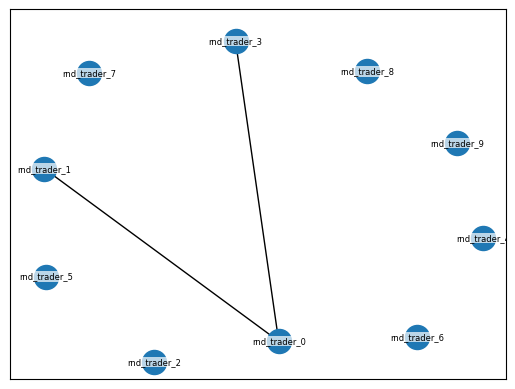

In [7]:
random.seed(42)

for run in range(1):
    model = Market_Model(N_agents = 10, Price = 10)
    
    N_steps = 1
    for step in range(N_steps):
        model.step()

### Initialization with erdos renyi

In [8]:
def get_ER_mapped_edges(N_agents, prob, labels):
    ER = nx.erdos_renyi_graph(N_agents, prob)
    list_edges = list(ER.edges())
    
    mapped_edges = list()
    for edge in list_edges:
        node1 = list(labels.keys())[list(labels.values()).index(f'rnd_trader_{edge[0]}')]
        node2 = list(labels.keys())[list(labels.values()).index(f'rnd_trader_{edge[1]}')]
        mapped_edges.append((node1, node2))
        
    return mapped_edges

In [9]:
class Market_Model(mesa.Model):
    def __init__(self, N_agents, Price):
        
        # Environment Settings
        self.schedule = mlm.MultiLevel_Mesa(self, group_to_net = True)
        
        # Model Parameters
        self.Price = Price; self.Last_Price = self.Price
        self.N_agents = N_agents
        
        # Create Random Traders
        N_rnd_traders = N_agents
        wealth = 400; position = 'null'; order = 0
        
        for a in range(N_rnd_traders):
            unique_id = f'rnd_trader_{a}'
            ag = Agent_Rnd_Trader(
                unique_id,
                self,
                wealth, position, order
            )
            self.schedule.add(ag)
        
        self.datacollector = mesa.datacollection.DataCollector(
            model_reporters = {'Price': change_Prices},
            agent_reporters = {
                'wealth': 'wealth',
                'position': 'position',
                'order': 'order'
            }
        )
        
    def step(self): 

        #specify criteria for group formation
        self.schedule.net_group(
            link_type = 'success',
            link_value = 5
        )
        
        #step the groups and agents
        self.schedule.step()
        
        G = self.schedule.net
        #pos = nx.spring_layout(G, k = 1) # for node positions
        pos = nx.random_layout(G)
        labels = get_graphlabels(self.schedule._agents)
        
        list_tuples = get_ER_mapped_edges(self.N_agents, 0.05, labels)
        G.add_edges_from(list_tuples)
        
        nx.draw_networkx_nodes(G, pos)
        nx.draw_networkx_edges(G, pos)
        nx.draw_networkx_labels(G, pos, labels, font_size=6, bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=0.5))
        plt.show();
        
        # Collect data at that timestep
        self.datacollector.collect(self)

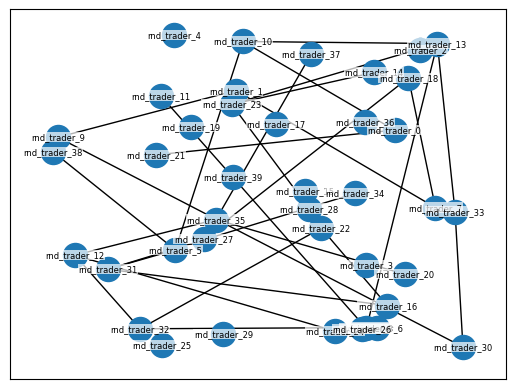

In [10]:
random.seed(42)

for run in range(1):
    model = Market_Model(N_agents = 40, Price = 10)

    N_steps = 1
    for step in range(N_steps):
        model.step()